In [1]:
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Activation(str, Enum):
    SIGMOID = "Sigmoid"
    SOFTMAX = "Softmax"
    RELU = "ReLU"

class Loss(str, Enum):
    MSE = "Mean Squared Error "
    CE = "Cross Entropy"
    
class Layer:
    def __init__(self, neurons, activation):
        self.activation = activation
        self.w = None        
        self.b = np.random.uniform(low=0, high=1, size=(neurons, 1))
        self.z = None
        self.a = None
        self.delta = []
        self.gradient_w= []
        self.gradient_b= []
        
    def neuronsCount(self):
        return self.b.size        
        
class FNN:
    def __init__(self, lossFunction, inputs):
        self.layers = []
        self.inputsNodes = 0
        self.next_index = 0
        self.lostHist = []
        self.x_train = None
        self.batch_size = 1   
        self.loss = []
        self.inputsNodes = inputs
        self.x_normalizeScalars = None
        self.y_normalizeScalars = None
        self.axisToNormalize = (None, None)
        self.lossFunction = lossFunction
        
    def activation(self, activ, z):
        if(activ == Activation.SIGMOID):
            return self.sigmoid(z)
        elif(activ == Activation.SOFTMAX):
            return self.softmax(z)
        else:
            return self.relu(z)
            
    def activation_derivative(self, activ, z):
        if(activ == Activation.SIGMOID):
            return self.sigmoid_derivative(z)
        elif(activ == Activation.RELU):
            return self.relu_derivative(z)
        else:
            return self.softmax_derivative(z)
            
    def MSE(self, a, y):
        return np.square((y-a))/2  
        
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))    
    
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1-self.sigmoid(z))
    
    def relu(self, z):
        return np.maximum(z,0)
    
    def relu_derivative(self, z):
        return (z >= 0).astype(int)  
    
    def softmax(self, z):
        return np.exp(z) / np.exp(z).sum(axis=0)
    
    def softmax_derivative(self, z):
        return self.softmax(z) * (1 - self.softmax(z))
    
    def crossEntropy(self, a, y):
        return -np.sum(y * np.log(a), axis = 0)
    
    def addLayer(self, activation, neurons):
        layer = Layer(neurons, activation)
        self.layers.append(layer)
        
    def addInputs(self, inputsCount):
        self.inputsNodes = inputsCount
        
    def set_weights(self, initValue = 1):
        for i, layer in enumerate(self.layers):
            if i == 0 :
                layer.w = np.random.uniform(low=0, high=initValue, size=(self.inputsNodes,layer.neuronsCount()))
            else:
                layer.w = np.random.uniform(low=0, high=initValue, size=(self.layers[i-1].neuronsCount(),layer.neuronsCount()))
            
    def evaluateOne(self, x_batch):
        for i,l in enumerate(self.layers):
            # Logit
            if i == 0:
                l.z = np.dot(l.w.T, x_batch) + l.b
            else:
                l.z = np.dot(l.w.T, self.layers[i-1].a) + l.b
            # Activation
            l.a = self.activation(l.activation, l.z)
  

    def backpropagation(self, x_batch, y_batch, rate):
        for j,l in enumerate(self.layers[::-1]):
            i = len(self.layers) - (1 + j)
            if i == len(self.layers) -1:
                if self.lossFunction == Loss.CE:
                    l.delta = l.a - y_batch
                else:
                    l.delta = (l.a - y_batch) * self.activation_derivative(l.activation, l.a)
                l.gradient_w = np.einsum('ij,jk->jik', self.layers[i-1].a, l.delta.T)
                l.gradient_w = np.mean(l.gradient_w, axis=0)
                l.gradient_b = np.mean(l.delta, axis=1)
            elif i == 0:
                l.delta = np.multiply(self.activation_derivative(l.activation, l.z), np.dot(self.layers[i+1].w, self.layers[i+1].delta))
                l.gradient_w= np.einsum('ij,jk->jik', x_batch, l.delta.T)
                l.gradient_w = np.mean(l.gradient_w, axis=0)
                l.gradient_b = np.mean(l.delta, axis=1)
            else:
                l.delta = np.multiply(self.activation_derivative(l.activation, l.z), np.dot(self.layers[i+1].w, self.layers[i+1].delta))
                l.gradient_w= np.einsum('ij,jk->jik', self.layers[i-1].a, l.delta.T)
                l.gradient_w = np.mean(l.gradient_w, axis=0)
                l.gradient_b = np.mean(l.delta, axis=1)
            
        for l in self.layers:
            l.gradient_b = l.gradient_b.reshape(len(l.gradient_b), 1)
            l.w -= rate*l.gradient_w
            l.b -= rate*l.gradient_b
            
    def train(self, x_train, y_train, epochs, rate, batch_size = 1):
        self.set_weights()        
        self.x_train = x_train
        self.y_train = y_train   

        if self.axisToNormalize[0] != None or self.axisToNormalize[1] != None:
            print("X normalization : {} | Y normalization : {}".format(self.axisToNormalize[0], self.axisToNormalize[1]))
            self.normalizeBackend(self.axisToNormalize[0], self.axisToNormalize[1])
        else :
            print("[Warning] Data not normalized")
            
        self.batch_size = batch_size   
        
        shuffleTime = int(np.ceil(len(self.x_train)/self.batch_size))        
       
        for epoch in range(epochs):
            idx = np.random.permutation(self.x_train.index)
            self.x_train = self.x_train.reindex(idx).reset_index(drop=True, inplace=False)
            self.y_train = self.y_train.reindex(idx).reset_index(drop=True, inplace=False)
            self.next_index = 0
            epochLoss = []            
            for it in range(shuffleTime):            
                current_index = self.next_index
                self.next_index = self.next_index + self.batch_size if self.next_index + self.batch_size < len(self.x_train) - 1 else 0

                x_batch = self.x_train.iloc[current_index:].to_numpy().T if self.next_index == 0 else self.x_train.iloc[current_index: self.next_index].to_numpy().T
                y_batch = np.vstack(self.y_train.iloc[current_index:].to_numpy()).T if self.next_index == 0 else np.vstack(self.y_train.iloc[current_index:self.next_index].to_numpy()).T        

                self.evaluateOne(x_batch)
                
                if self.lossFunction == Loss.CE:
                    loss = np.mean(self.crossEntropy(self.layers[-1].a, y_batch))
                else:
                    loss = np.mean(self.MSE(self.layers[-1].a, y_batch))    
                    
                epochLoss.append(loss)
                self.backpropagation(x_batch, y_batch, rate)
            if(epoch% 100 == 0 or epoch == epochs-1):
                print("Epoch {} / {} - Loss : {}".format(epoch+1, epochs, np.mean(epochLoss)))
            self.loss.append(np.mean(epochLoss))
            
    def normalizeBackend(self, x, y):
        if x is True:
            self.x_normalizeScalars = (self.x_train.min(axis=0), self.x_train.max(axis=0))
            self.x_train = (self.x_train - self.x_normalizeScalars[0]) / (self.x_normalizeScalars[1] - self.x_normalizeScalars[0])
        if y is True:
            self.y_normalizeScalars = (self.y_train.min(axis=0), self.y_train.max(axis=0))
            self.y_train = (self.y_train - self.y_normalizeScalars[0]) / (self.y_normalizeScalars[1] - self.y_normalizeScalars[0])
            
    def normalize(self, x=True, y=False):
        self.axisToNormalize = (x,y)
    
    def predict(self, x_batch, returnValue = False):
        if self.axisToNormalize[0] != None:
            print("X normalization : {} ".format(self.axisToNormalize[0]))
            x_batch = (x_batch - self.x_normalizeScalars[0]) / (self.x_normalizeScalars[1] - self.x_normalizeScalars[0])
        x_batch_T = x_batch.to_numpy().T
        self.evaluateOne( x_batch_T)
        if returnValue:
            return self.layers[-1].a
        else:
            pass
    
    def test(self, y, y_pred = None):
        y_original = y.copy()
        y_original = np.stack(y_original.to_numpy()).T

        if(y_pred == None):
            y_pred = self.layers[-1].a
        # Transpose Y (observations in columns)
        if self.axisToNormalize[1] is True:
            print("Y normalization : {} ".format(self.axisToNormalize[1]))
            y = (y - self.y_normalizeScalars[0]) / (self.y_normalizeScalars[1] - self.y_normalizeScalars[0])
        y = np.stack(y.to_numpy()).T
        
        if self.lossFunction == Loss.CE:
            # Good prediciton rate
            max_indices = np.argmax(y_pred, axis=0)
            matching_counts = np.sum(y[max_indices, np.arange(y_pred.shape[1])])
            print("Good prediction : {}/{} | {}%".format(matching_counts, len(max_indices), (matching_counts * 100) / len(max_indices)))
            print("Loss : {}\n".format(np.mean(self.crossEntropy(y_pred, y))))
        else:

            df_test = pd.DataFrame({'Ypred': y_pred[0], 'YobsNormalized': y})
            df_test["difNormalized"] = y_pred[0] - y
            df_test["YpredDeNormalized"] = y_pred[0] * (self.y_normalizeScalars[1] -self.y_normalizeScalars[0]) + self.y_normalizeScalars[0]
            df_test["Yobs"] = y_original
            df_test["difDeNormalized"] = df_test["YpredDeNormalized"] - df_test["Yobs"]
            df_test["loss"] = self.MSE(y_pred, y)[0]            
            display(df_test)
            print("Loss : {}\n".format(np.mean(self.MSE(y_pred, y))))
        # Plot loss over epochs
        plt.plot(model.loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over epochs')

In [12]:
np.random.seed(42)
np.set_printoptions(linewidth=np.inf)

def combine_to_list(row):
    return np.array([row['Iris-setosa'], row['Iris-versicolor'], row['Iris-virginica']])

# Load csv
df = pd.read_csv("iris_csv.csv")

# One hot econding class
classCols = pd.get_dummies(df['class'], prefix='', prefix_sep='')
df = pd.concat([df, classCols.apply(combine_to_list, axis = 1)], axis=1)
df.drop(['class'], axis=1, inplace=True)

# shuffle before split
df = df.sample(frac = 1).reset_index(drop=True, inplace=False)

# Split train/test
msk = np.random.rand(len(df)) < 0.8
train, test = df[msk], df[~msk]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Split training data between X and Y

#(split like this for a classification task)
#y_train = train[0]
#x_train = train.iloc[:, :-1]

# (split like this for a regresion task)
x_train = train[["sepallength", "sepalwidth", "petalwidth"]]
y_train = train.petallength

# Split test data between X and Y

#(split like this for a classification task)
#y_test = test[0]
#x_test = test.iloc[:, :-1]

# (split like this for a regresion task)
y_test = test.petallength
x_test = test[["sepallength", "sepalwidth", "petalwidth"]]

In [24]:
model = FNN(Loss.MSE, inputs = 3)
model.normalize(x = True, y = True)
model.addLayer(Activation.SIGMOID, neurons = 3)
model.addLayer(Activation.SIGMOID, neurons = 1)
model.train(x_train, y_train, epochs = 10000, rate = .01, batch_size = 5)

X normalization : True | Y normalization : True
Epoch 1 / 10000 - Loss : 0.11186551131450523
Epoch 101 / 10000 - Loss : 0.045000857827336864
Epoch 201 / 10000 - Loss : 0.04463943273195982
Epoch 301 / 10000 - Loss : 0.0444330872049954
Epoch 401 / 10000 - Loss : 0.04421522290468608
Epoch 501 / 10000 - Loss : 0.04398908402472048
Epoch 601 / 10000 - Loss : 0.04375612281373016
Epoch 701 / 10000 - Loss : 0.04349918070655827
Epoch 801 / 10000 - Loss : 0.04322830422141712
Epoch 901 / 10000 - Loss : 0.04291760797969622
Epoch 1001 / 10000 - Loss : 0.04257160644534298
Epoch 1101 / 10000 - Loss : 0.04218433602857399
Epoch 1201 / 10000 - Loss : 0.04172580262211499
Epoch 1301 / 10000 - Loss : 0.04121369078013752
Epoch 1401 / 10000 - Loss : 0.04062001617580301
Epoch 1501 / 10000 - Loss : 0.039931576062434866
Epoch 1601 / 10000 - Loss : 0.03912473074814373
Epoch 1701 / 10000 - Loss : 0.03819010046072188
Epoch 1801 / 10000 - Loss : 0.03709623191997967
Epoch 1901 / 10000 - Loss : 0.035832163332626156
Ep

In [25]:
model.predict(x_test)

X normalization : True 


Y normalization : True 


,Ypred,YobsNormalized,difNormalized,YpredDeNormalized,Yobs,difDeNormalized,loss
0,0.831822,0.694915,0.136907,5.907752,5.1,0.807752,0.009372
1,0.733496,0.593220,0.140276,5.327626,4.5,0.827626,0.009839
2,0.758979,0.694915,0.064063,5.477974,5.1,0.377974,0.002052
3,0.080741,0.067797,0.012945,1.476373,1.4,0.076373,0.000084
4,0.080293,0.084746,-0.004453,1.473730,1.5,-0.026270,0.000010
5,0.622572,0.627119,-0.004547,4.673174,4.7,-0.026826,0.000010
6,0.806067,0.813559,-0.007492,5.755797,5.8,-0.044203,0.000028
7,0.696975,0.661017,0.035958,5.112154,4.9,0.212154,0.000647
8,0.096778,0.101695,-0.004917,1.570988,1.6,-0.029012,0.000012
9,0.084461,0.101695,-0.017234,1.498322,1.6,-0.101678,0.000148


Loss : 0.002066111583602015



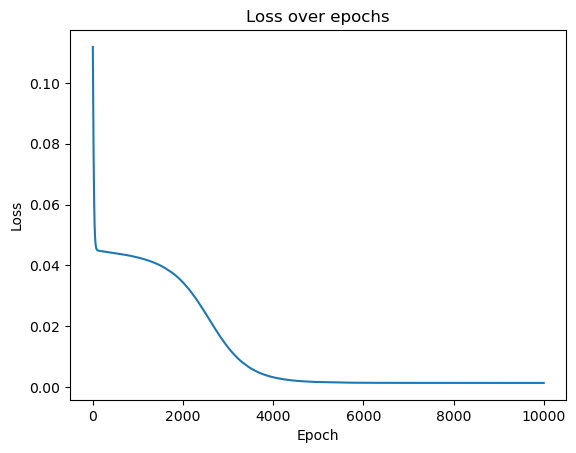

In [26]:
model.test(y_test)